# Bitcoin Price (1000+ days) Predictions - LSTM & GRU
- **RMSE**: LSTM (1759.30) slightly outperforms GRU (1789.62)
- **MAE**: LSTM (1169.44) is lower than GRU (1353.18)
- **R²** Score: LSTM (0.9933) is marginally better than GRU (0.9931)

**LSTM** performs slightly better in all key metrics, though the difference is small. Also, the computational cost between both is unobservable, providing aditional advantage to **LSTM** architecture.

To improve models & RMSE:
- increase `batch_size`
- increase or decrease `n_steps` in **split_sequence**
- train on more epochs
- improve model structure (especially GRU)
- restrict dataset (e.g. start from 2017)
- separate normalization over different time windows
- extend `train_set` (e.g. to 0.85)
- try various activation functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [2]:
def evaluate_model(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    r2 = r2_score(test, predicted)
    msle = mean_squared_log_error(test, predicted)
    mape = np.mean(np.abs((test - predicted) / test)) * 100

    print(f"The root mean squared error (RMSE) is {rmse:.2f}")
    print(f"The Mean Absolute Error (MAE) is {mae:.2f}")
    print(f"The R-squared (R²) score is {r2:.4f}\n")
    print(f"The Mean Squared Logarithmic Error (MSLE) is {msle:.6f}")
    print(f"The Mean Absolute Percentage Error (MAPE) is {mape:.2f}%.")

In [3]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

In [4]:
def train_test_plot(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    dataset.loc[tstart:tend, "Price"].plot(figsize=(16, 5), legend=True)
    dataset.loc[tend_next:, "Price"].plot(figsize=(16, 5), legend=True)

    plt.legend([f"Train (2010-07-18 to {tend_next.date()})", f"Test ({tend_next.date() + pd.Timedelta(days=1)} up to 2025-01-01)"])
    plt.title("Bitcoin Price")
    plt.show()

In [ ]:
def train_test_split(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset.loc[tstart:tend, "Price"].values
    test = dataset.loc[tend_next:, "Price"].values
    return train, test

In [6]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
dataset = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', parse_dates=['Date'], index_col = "Date")

In [ ]:
# train-test 0.8/0.2
tstart = "2010-07-18"
tend = "2022-02-10"

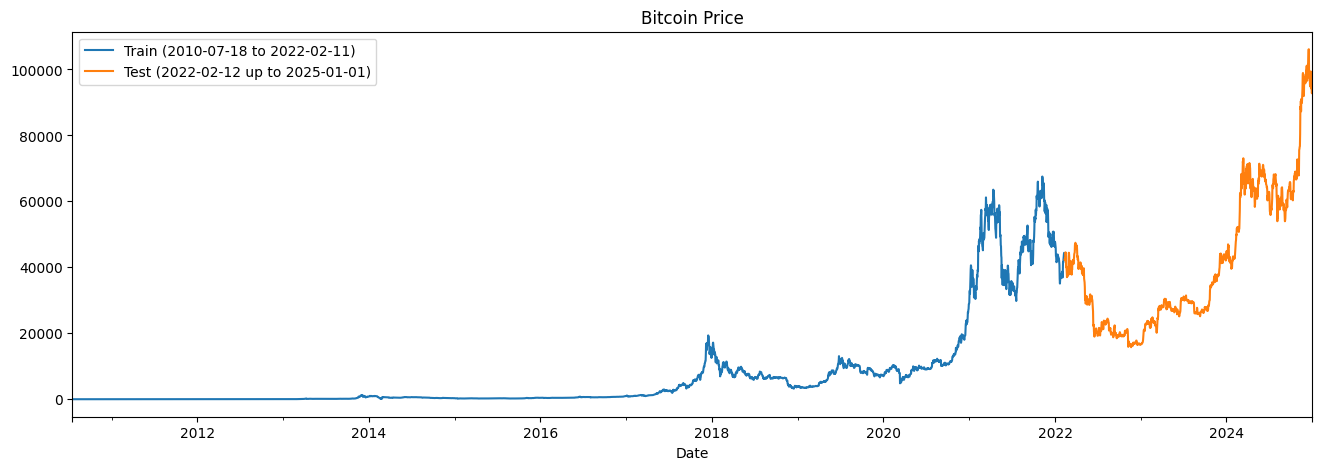

In [9]:
train_test_plot(dataset, tstart, tend)

In [10]:
training_set, test_set = train_test_split(dataset, tstart, tend)

In [11]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [12]:
n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [13]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

# LSTM

In [ ]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
131/131 [==============================] - 6s 35ms/step - loss: 0.0017
Epoch 2/50
131/131 [==============================] - 4s 30ms/step - loss: 5.2410e-04
Epoch 3/50
131/131 [==============================] - 5s 40ms/step - loss: 3.5706e-04
Epoch 4/50
131/131 [==============================] - 6s 44ms/step - loss: 3.1870e-04
Epoch 5/50
131/131 [==============================] - 6s 44ms/step - loss: 2.4510e-04
Epoch 6/50
131/131 [==============================] - 6s 44ms/step - loss: 2.4441e-04
Epoch 7/50
131/131 [==============================] - 5s 41ms/step - loss: 2.2101e-04
Epoch 8/50
131/131 [==============================] - 5s 42ms/step - loss: 2.0230e-04
Epoch 9/50
131/131 [==============================] - 5s 39ms/step - loss: 1.9701e-04
Epoch 10/50
131/131 [==============================] - 5s 39ms/step - loss: 1.7469e-04
Epoch 11/50
131/131 [==============================] - 5s 38ms/step - loss: 1.7563e-04
Epoch 12/50
131/131 [==============================] - 5

In [16]:
dataset_total = dataset.loc[:, "Price"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_bitcoin = model_lstm.predict(X_test)
#inverse transform the values
predicted_bitcoin = sc.inverse_transform(predicted_bitcoin)

33/33 [==============================] - 1s 21ms/step


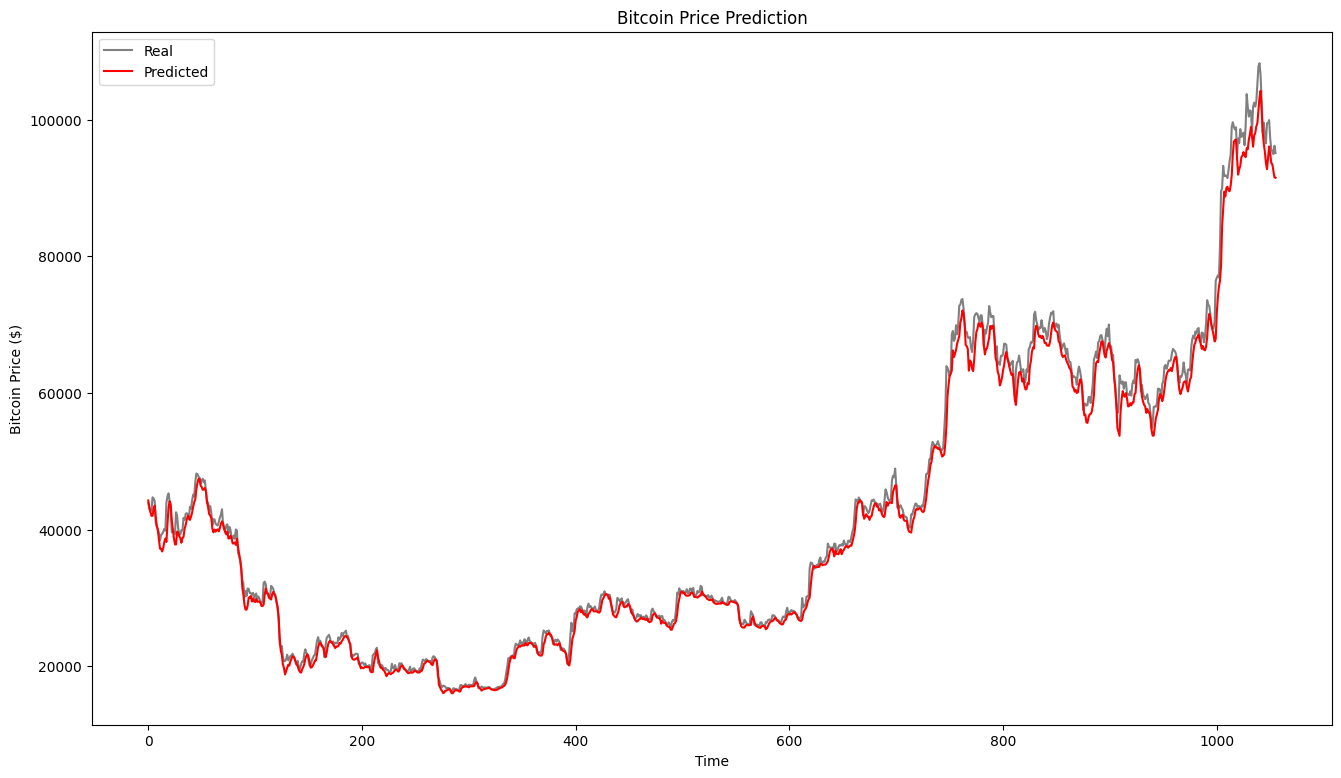

In [17]:
plot_predictions(test_set, predicted_bitcoin)

In [ ]:
evaluate_model(test_set, predicted_bitcoin)

The root mean squared error (RMSE) is 1759.30
The Mean Absolute Error (MAE) is 1169.44
The R-squared (R²) score is 0.9933

The Mean Squared Logarithmic Error (MSLE) is 0.001244
The Mean Absolute Percentage Error (MAPE) is 63.61%.


# GRU

In [20]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer="RMSprop", loss="mse")
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
131/131 [==============================] - 5s 26ms/step - loss: 0.0019
Epoch 2/50
131/131 [==============================] - 7s 52ms/step - loss: 3.8564e-04
Epoch 3/50
131/131 [==============================] - 7s 51ms/step - loss: 2.9898e-04
Epoch 4/50
131/131 [==============================] - 8s 58ms/step - loss: 2.9227e-04
Epoch 5/50
131/131 [==============================] - 8s 62ms/step - loss: 2.4031e-04
Epoch 6/50
131/131 [==============================] - 9s 65ms/step - loss: 2.3038e-04
Epoch 7/50
131/131 [==============================] - 8s 62ms/step - loss: 2.2178e-04
Epoch 8/50
131/131 [==============================] - 8s 63ms/step - loss: 1.9695e-04
Epoch 9/50
131/131 [==============================] - 8s 62ms/step - loss: 1.9680e-04
Epoch 10/50
131/131 [==============================] - 8s 62ms/step - loss: 1.7271e-04
Epoch 11/50
131/131 [==============================] - 8s 62ms/step - loss: 1.7594e-04
Epoch 12/50
131/131 [==============================] - 8

33/33 [==============================] - 1s 9ms/step


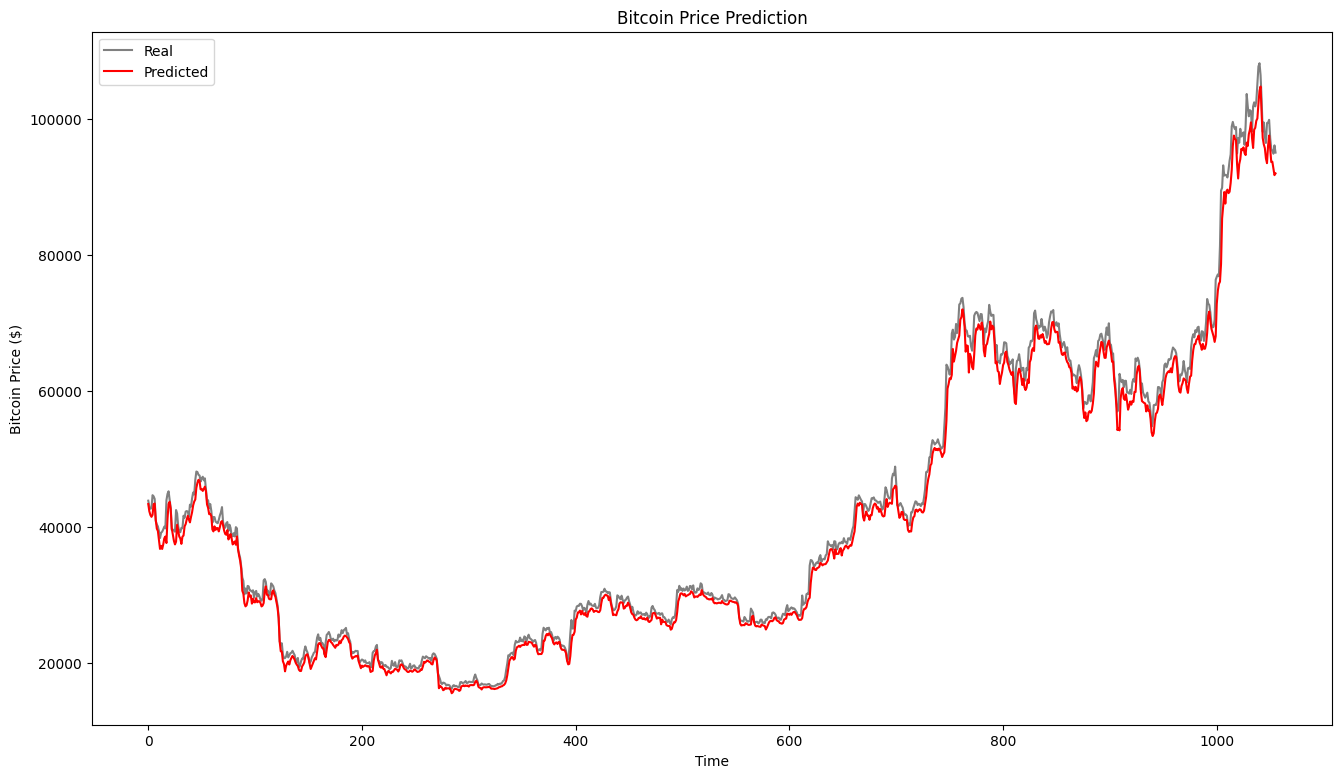

In [22]:
GRU_predicted_bitcoin = model_gru.predict(X_test)
GRU_predicted_bitcoin = sc.inverse_transform(GRU_predicted_bitcoin)
plot_predictions(test_set, GRU_predicted_bitcoin)

In [ ]:
evaluate_model(test_set, GRU_predicted_bitcoin)

The root mean squared error (RMSE) is 1789.62
The Mean Absolute Error (MAE) is 1353.18
The R-squared (R²) score is 0.9931

The Mean Squared Logarithmic Error (MSLE) is 0.001575
The Mean Absolute Percentage Error (MAPE) is 63.60%.


# Bidirectional LSTM

In [29]:
# The Bidirectional LSTM architecture
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=125, activation="tanh", input_shape=(n_steps, features))))
model_bilstm.add(Dense(units=1))
model_bilstm.compile(optimizer="RMSprop", loss="mse")
model_bilstm.build(input_shape=(None, n_steps, features))
model_bilstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 250)              127000    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 251       
                                                                 
Total params: 127,251
Trainable params: 127,251
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
131/131 [==============================] - 7s 39ms/step - loss: 0.0017
Epoch 2/50
131/131 [==============================] - 5s 40ms/step - loss: 6.4250e-04
Epoch 3/50
131/131 [==============================] - 6s 42ms/step - loss: 4.4330e-04
Epoch 4/50
131/131 [==============================] - 7s 56ms/step - loss: 4.0256e-04
Epoch 5/50
131/131 [==============================] - 8s 64ms/step - loss: 2.9870e-04
Epoch 6/50
131/131 [==============================] - 8s 64ms/step - loss: 3.0603e-04
Epoch 7/50
131/131 [==============================] - 8s 58ms/step - loss: 2.7768e-04
Epoch 8/50
131/131 [==============================] - 8s 60ms/step - loss: 2.4925e-04
Epoch 9/50
131/131 [==============================] - 8s 58ms/step - loss: 2.4325e-04
Epoch 10/50
131/131 [==============================] - 8s 57ms/step - loss: 2.1329e-04
Epoch 11/50
131/131 [==============================] - 8s 58ms/step - loss: 2.1120e-04
Epoch 12/50
131/131 [==============================] - 8

33/33 [==============================] - 0s 14ms/step


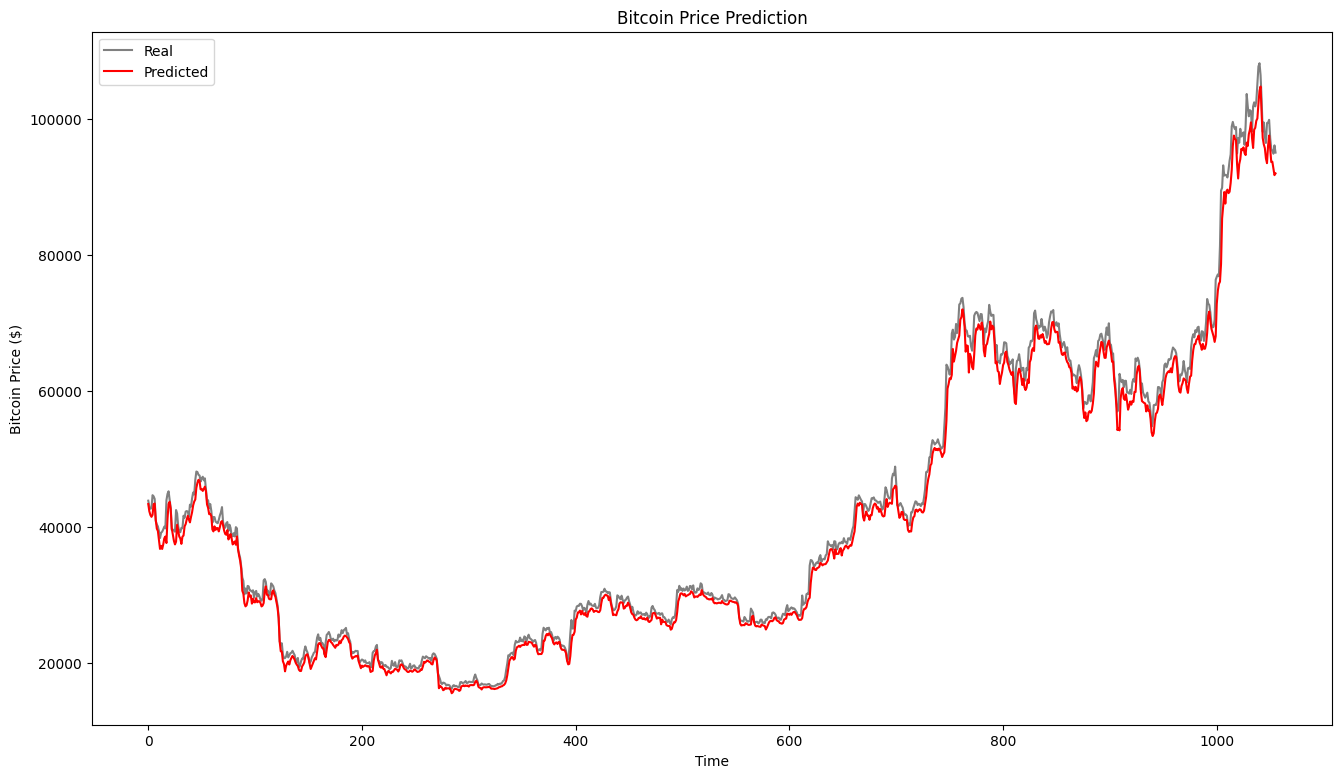

In [31]:
BILSTM_predicted_bitcoin = model_gru.predict(X_test)
BILSTM_predicted_bitcoin = sc.inverse_transform(BILSTM_predicted_bitcoin)
plot_predictions(test_set, BILSTM_predicted_bitcoin)

In [32]:
evaluate_model(test_set, BILSTM_predicted_bitcoin)

The root mean squared error (RMSE) is 1789.62
The Mean Absolute Error (MAE) is 1353.18
The R-squared (R²) score is 0.9931

The Mean Squared Logarithmic Error (MSLE) is 0.001575
The Mean Absolute Percentage Error (MAPE) is 63.60%.
